# Modelling

This code imports essential libraries and modules for machine learning. It includes pandas for data handling, preprocessing tools (one-hot encoding, scaling), model selection techniques (train-test split, cross-validation, grid search), and classifiers such as logistic regression, random forest, XGBoost, and AdaBoost for building and tuning predictive models.

In [36]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

Loading the feature engineered dataset into a pandas dataframe

In [37]:
df = pd.read_csv('feature_engineered.csv')
df.head()

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,...,policy_bind_date_year,policy_bind_date_cosine_month,policy_bind_date_sine_month,policy_bind_date_cosine_day,policy_bind_date_sine_day,incident_date_year,incident_date_cosine_month,incident_date_sine_month,incident_date_cosine_day,incident_date_sine_day
0,328,48,OH,250/500,1000,1406.91,0,MALE,MD,craft-repair,...,2014,5.000000e-01,-8.660254e-01,-8.660254e-01,5.000000e-01,2015,0.866025,0.500000,8.660254e-01,0.500000
1,228,42,IN,250/500,2000,1197.22,5000000,MALE,MD,machine-op-inspct,...,2006,-1.000000e+00,1.224647e-16,5.510911e-16,1.000000e+00,2015,0.866025,0.500000,-4.286264e-16,-1.000000
2,134,29,OH,100/300,2000,1413.14,5000000,FEMALE,PhD,sales,...,2000,-1.836970e-16,-1.000000e+00,-1.000000e+00,1.224647e-16,2015,0.500000,0.866025,5.000000e-01,-0.866025
3,256,41,IL,250/500,2000,1415.74,6000000,FEMALE,PhD,armed-forces,...,1990,-8.660254e-01,5.000000e-01,8.660254e-01,5.000000e-01,2015,0.866025,0.500000,5.000000e-01,-0.866025
4,228,44,IL,500/1000,1000,1583.91,6000000,MALE,Associate,sales,...,2014,-1.000000e+00,1.224647e-16,-1.000000e+00,1.224647e-16,2015,0.500000,0.866025,-8.660254e-01,0.500000


Checking For duplicates and Missing values yet again

In [38]:
print('Duplicated rows:', df.duplicated().sum())
print('Missing values:', df.isna().sum().sum())

Duplicated rows: 0
Missing values: 0


Importing pipeline model

In [39]:

from sklearn.pipeline import Pipeline
import numpy as np

In [40]:
from utils.modelling import get_preprocessor
preprocessor = get_preprocessor(df, 'fraud_reported')

## Splitting to train and test data

In [41]:
# Defining X and y
X = df.drop(columns=['fraud_reported']) 
y = df['fraud_reported']

#performing LabelEncoding
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y = lb.fit_transform(y)
y.shape = (-1,)


# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=42)

In [42]:
# preprocessing the features
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [43]:
lb.classes_

array(['N', 'Y'], dtype='<U1')

`0 represents N: not fraud case`

`1 represents Y: fraud case`

In [44]:
df['fraud_reported'].value_counts(normalize=True)

fraud_reported
N    0.753
Y    0.247
Name: proportion, dtype: float64

Noted some class imbalance in the target column. 

In [45]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import (
    recall_score,
    precision_score,
    f1_score,
    accuracy_score
)

The Modeling class trains and evaluates a machine learning model with preprocessing, optionally using SMOTE for class imbalance. It provides methods to train the model with and without SMOTE, conducts cross-validation, and evaluates accuracy, recall, precision, and F1 scores on test data, highlighting performance differences.

In [46]:
class Modeling:
    """Class to carry out model fiting and cross validation
    Attributes:
        model: The model 
        X_train: training features
        y_train: target
    """
    def __init__(self, model, preprocessor, X_train, y_train):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.preprocessor = preprocessor
        self.fitted_base_model = None
        self.fitted_smote_model = None

    def train_base(self):
        """Fif with only preprocessing which only includes scaling and ohe"""
        # Fit the model
        model_pipe = Pipeline([
            ('preprocessing', clone(self.preprocessor)),
            ('model', clone(self.model))
        ])
        score = cross_val_score(model_pipe,
                                self.X_train,
                                self.y_train,
                                scoring='accuracy',
                                ).mean() 
        print('**************************************************************************')
        print("\n"f"The model(with normal preprocessing) has an accuracy of {score*100:.2f}%")
        self.fitted_base_model = model_pipe
        self.fitted_base_model.fit(self.X_train, self.y_train)
        return self.fitted_base_model
        
    def train_with_smote(self):
        """Includes oversampling with smote to reduce class imbalance"""
        # Perform custom Cross-Validation to include smote
        scores = []
        # splits for cross validation
        skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
        for i, (train_idx, test_idx) in enumerate(skf.split(self.X_train, self.y_train)):
            # train and test data for the validation
            cv_X_train = self.X_train.iloc[train_idx, :]
            cv_X_test = self.X_train.iloc[test_idx, :]
            cv_y_train = self.y_train[train_idx]
            cv_y_test = self.y_train[test_idx]
            
            preprocessor_clone = clone(self.preprocessor)
            
            # preprocessing the features
            cv_X_train_preprocessed = preprocessor_clone.fit_transform(cv_X_train)
            cv_X_test_preprocessed = preprocessor_clone.transform(cv_X_test)
            
            
            # cloning the model
            model_clone = clone(self.model)
            
            # oversampling with smote to fix class imbalance
            X_oversampled, y_oversampled = (
                SMOTE(random_state=42).fit_resample(cv_X_train_preprocessed,
                                                    cv_y_train))
            
            # convert to dataframe
            X_oversampled = pd.DataFrame(X_oversampled, 
                                         columns=preprocessor_clone.get_feature_names_out())
            
            # fit and obtain score for the current fold
            model_clone.fit(X_oversampled, y_oversampled)
            score = model_clone.score(cv_X_test_preprocessed, cv_y_test)
            print(f"Fold {i+1}: Accuracy = {score * 100:.2f}%")
            scores.append(score)
        
        # define model to return
        
        # preprocess on whole train data 
        cv_X_train_preprocessed = preprocessor.fit_transform(self.X_train)
        # oversample whole training data
        X_oversampled, y_oversampled = (
            SMOTE(random_state=42).fit_resample(cv_X_train_preprocessed,
                                                self.y_train))
        
        print('**********************************************************************')
        print("\n"f"The model(with SMOTE) has an accuracy of {np.mean(scores)*100:.2f}%")
        
        # fit and return the model
        self.fitted_smote_model = clone(self.model)
        self.fitted_smote_model.fit(X_oversampled, y_oversampled)
        return self.fitted_smote_model
    
    def evaluate_on_test(self, X_test, y_test):
        """evaluates the model on unseen test data"""
        if self.fitted_base_model:
            print('Without SMOTE:')
            y_pred = self.fitted_base_model.predict(X_test)
            print('\tAccuracy score:', accuracy_score(y_test, y_pred))
            print('\tRecall Score:', recall_score(y_test, y_pred))
            print('\tPrecision Score:', precision_score(y_test, y_pred))
            print('\tF1 Score:', f1_score(y_test, y_pred))
            
        if self.fitted_smote_model:
            print('\n With SMOTE:')
            X_test_preprocessed = self.preprocessor.transform(X_test)
            y_pred = self.fitted_smote_model.predict(X_test_preprocessed)
            print('\tAccuracy score:', accuracy_score(y_test, y_pred))
            print('\tRecall Score:', recall_score(y_test, y_pred))
            print('\tPrecision Score:', precision_score(y_test, y_pred))
            print('\tF1 Score:', f1_score(y_test, y_pred))    
            

### Logistic Regression .

In [47]:
log_reg = LogisticRegression(solver='liblinear')

model_1 = Modeling(log_reg, preprocessor, X_train, y_train)
print('Logistic Regression model')
fitted_model_1 = model_1.train_base()

Logistic Regression model
**************************************************************************

The model(with normal preprocessing) has an accuracy of 81.73%


In [48]:
fitted_model_1_smote = model_1.train_with_smote()

c:\Users\mutis\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\mutis\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\mutis\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\mutis\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\mutis\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\mutis\anaconda3\envs\tf\lib\sit

Fold 1: Accuracy = 80.00%
Fold 2: Accuracy = 74.40%
Fold 3: Accuracy = 84.00%
Fold 4: Accuracy = 80.80%
Fold 5: Accuracy = 82.40%
Fold 6: Accuracy = 84.00%
**********************************************************************

The model(with SMOTE) has an accuracy of 80.93%


### Random Forest .

In [49]:
rf_clf = RandomForestClassifier()
model_2 = Modeling(rf_clf, preprocessor, X_train, y_train)

In [50]:
print('Random Forest model')
fitted_model_2 = model_2.train_base()

Random Forest model
**************************************************************************

The model(with normal preprocessing) has an accuracy of 77.07%


In [51]:
fitted_model_2_smote = model_2.train_with_smote()

c:\Users\mutis\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Fold 1: Accuracy = 77.60%


c:\Users\mutis\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Fold 2: Accuracy = 77.60%


c:\Users\mutis\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Fold 3: Accuracy = 76.80%


c:\Users\mutis\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Fold 4: Accuracy = 76.80%


c:\Users\mutis\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Fold 5: Accuracy = 80.00%


c:\Users\mutis\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Fold 6: Accuracy = 76.00%
**********************************************************************

The model(with SMOTE) has an accuracy of 77.47%


### XGBClassifier

In [52]:
xgb = XGBClassifier(
    colsample_bytree=1.0,
    gamma=0,
    learning_rate=0.2,
    max_depth=7,
    n_estimators=100,
    subsample=1.0,
    scale_pos_weight=3,
    eval_metric='logloss',  # Optional, based on your metric of choice
    #use_label_encoder=False
)
model_3 = Modeling(xgb, preprocessor, X_train, y_train)

In [53]:
print('XGBoost classifier model')
fitted_model_3 = model_3.train_base()

XGBoost classifier model
**************************************************************************

The model(with normal preprocessing) has an accuracy of 83.60%


In [54]:
fitted_model_3_smote = model_3.train_with_smote()

Fold 1: Accuracy = 82.40%
Fold 2: Accuracy = 80.80%
Fold 3: Accuracy = 87.20%
Fold 4: Accuracy = 88.80%
Fold 5: Accuracy = 85.60%
Fold 6: Accuracy = 85.60%
**********************************************************************

The model(with SMOTE) has an accuracy of 85.07%


In [55]:
fitted_model_3_smote = model_3.train_with_smote()

Fold 1: Accuracy = 82.40%
Fold 2: Accuracy = 80.80%
Fold 3: Accuracy = 87.20%
Fold 4: Accuracy = 88.80%
Fold 5: Accuracy = 85.60%
Fold 6: Accuracy = 85.60%
**********************************************************************

The model(with SMOTE) has an accuracy of 85.07%


### AdaBoostClassifier

In [56]:
ada = AdaBoostClassifier()
model_4 = Modeling(ada, preprocessor, X_train, y_train)

In [57]:
print('AdaBoost model')
fitted_model_4 = model_4.train_base()

AdaBoost model


c:\Users\mutis\anaconda3\envs\tf\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\mutis\anaconda3\envs\tf\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\mutis\anaconda3\envs\tf\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\mutis\anaconda3\envs\tf\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warnin

**************************************************************************

The model(with normal preprocessing) has an accuracy of 80.40%


In [58]:
fitted_model_4_smote = model_4.train_with_smote()

c:\Users\mutis\anaconda3\envs\tf\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\mutis\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\Users\mutis\anaconda3\envs\tf\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Fold 1: Accuracy = 82.40%


c:\Users\mutis\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\Users\mutis\anaconda3\envs\tf\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Fold 2: Accuracy = 75.20%


c:\Users\mutis\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\Users\mutis\anaconda3\envs\tf\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Fold 3: Accuracy = 81.60%


c:\Users\mutis\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\Users\mutis\anaconda3\envs\tf\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Fold 4: Accuracy = 80.80%


c:\Users\mutis\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\Users\mutis\anaconda3\envs\tf\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Fold 5: Accuracy = 80.00%


c:\Users\mutis\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\Users\mutis\anaconda3\envs\tf\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Fold 6: Accuracy = 79.20%
**********************************************************************

The model(with SMOTE) has an accuracy of 79.87%


The logistic regression model and the xgboost are the best performing with higher accuracy.

# Evaluating on unseen test Data

In [59]:
print('*********Logistic Regression******************')
model_1.evaluate_on_test(X_test, y_test)

*********Logistic Regression******************
Without SMOTE:
	Accuracy score: 0.732
	Recall Score: 0.34328358208955223
	Precision Score: 0.5
	F1 Score: 0.40707964601769914

 With SMOTE:
	Accuracy score: 0.764
	Recall Score: 0.6865671641791045
	Precision Score: 0.5476190476190477
	F1 Score: 0.609271523178808


In [60]:
print('*********XGBoost Classifier*****************')
model_3.evaluate_on_test(X_test, y_test)

*********XGBoost Classifier*****************
Without SMOTE:
	Accuracy score: 0.8
	Recall Score: 0.6716417910447762
	Precision Score: 0.6164383561643836
	F1 Score: 0.6428571428571429

 With SMOTE:
	Accuracy score: 0.804
	Recall Score: 0.6716417910447762
	Precision Score: 0.625
	F1 Score: 0.6474820143884892


# Evaluation

After the modelling process and evaluation on unseen test data, the XGBoost classifier has higher accuracy but we want a sensitive model and therefore we choose the `Logistic regression model `as the final model due the the high sesnitivity(recall = 67.16%).

In [61]:
#Gridsearch
log_reg =LogisticRegression()
# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10,100,1000],          # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['saga', 'liblinear']  # Solvers compatible with chosen penalties
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, scoring='accuracy', n_jobs=-1, verbose=1)

X_train_oversampled ,y_train_oversampled =SMOTE(random_state=42).fit_resample(X_train_preprocessed,y_train)

# Fit GridSearchCV to the data
grid_search.fit(X_train_oversampled , y_train_oversampled)

# Get best parameters and recall score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation recall score: {:.2f}".format(grid_search.best_score_))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found:  {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
Best cross-validation recall score: 0.90


c:\Users\mutis\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [62]:
final_model = LogisticRegression(C=1 ,penalty ='l1',solver='liblinear')
final_model.fit(X_train_oversampled,y_train_oversampled)


LogisticRegression(C=1, penalty='l1', solver='liblinear')

## Testing on Unseen Data .

In [63]:
y_preds = final_model.predict(X_test_preprocessed)
recall_score(y_test,y_preds)


0.7164179104477612

## Plotting ROC curve and Confusion Matrix

This code cell below  evaluates a classification model by calculating accuracy, recall, precision, F1 score, and ROC-AUC. It visualizes the confusion matrix with a heatmap to show prediction accuracy for 'No Fraud' and 'Fraud' classes. Additionally, it plots the ROC curve, displaying the model's ability to distinguish classes.

Accuracy Score: 0.8
Recall Score: 0.7164179104477612
Precision Score: 0.6075949367088608
F1 Score: 0.6575342465753424


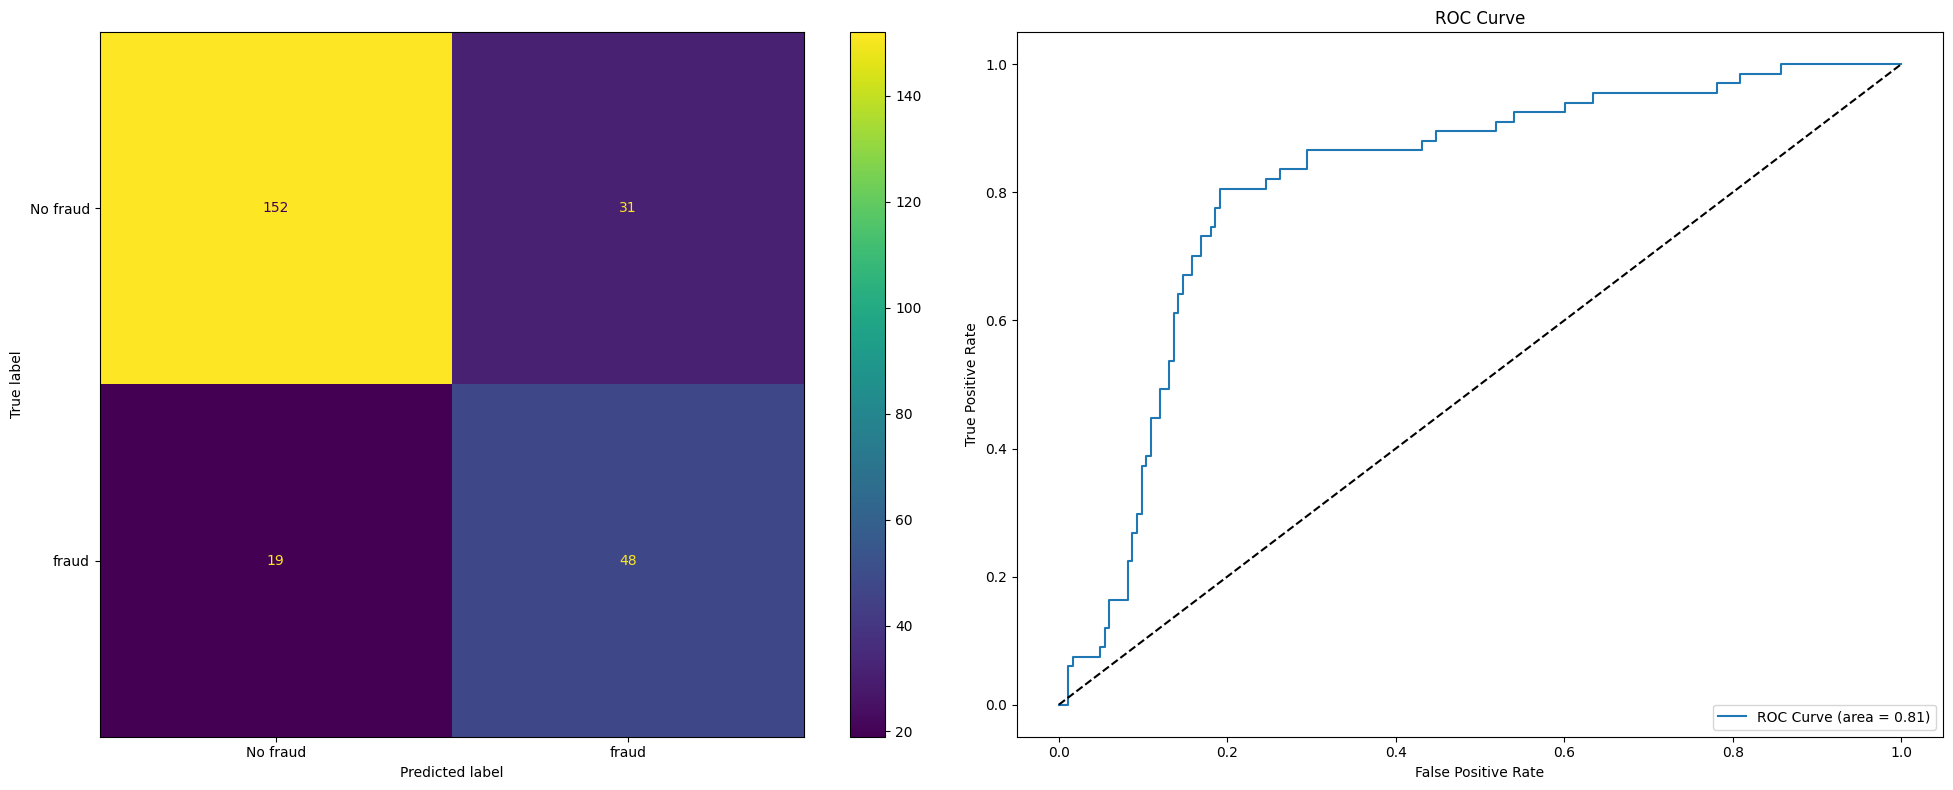

In [64]:
from sklearn.metrics import (
    recall_score,
    precision_score, 
    f1_score,
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

y_pred_proba = final_model.predict_proba(X_test_preprocessed)[:, 1] 
# Calculate evaluation metrics
print("Accuracy Score:", accuracy_score(y_test, y_preds))
print("Recall Score:", recall_score(y_test, y_preds))
print("Precision Score:", precision_score(y_test, y_preds))
print("F1 Score:", f1_score(y_test, y_preds))
#print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(
    conf_matrix,
    display_labels=['No fraud', 'fraud']
)
disp.plot(ax=axes[0])

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
axes[1].plot(
    fpr,
    tpr,
    label=f'ROC Curve (area = {roc_auc_score(y_test, y_pred_proba):.2f})'
)
axes[1].plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc="lower right")
plt.tight_layout();


## Matrix Summary

In [65]:
from sklearn.metrics import classification_report
conf_matrix = confusion_matrix(y_test, y_preds)
# Extract TP, TN, FP, FN from the confusion matrix
TN, FP, FN, TP = conf_matrix.ravel()

In [66]:
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")

True Positives (TP): 48
True Negatives (TN): 152
False Positives (FP): 31
False Negatives (FN): 19



True Positives (TP): 49 — Cases correctly predicted as positive.<br>
True Negatives (TN): 147 — Cases correctly predicted as negative.<br>
False Positives (FP): 36 — Cases incorrectly predicted as positive.<br>
False Negatives (FN): 18 — Cases incorrectly predicted as negative.<br>

In [67]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86       183
           1       0.61      0.72      0.66        67

    accuracy                           0.80       250
   macro avg       0.75      0.77      0.76       250
weighted avg       0.81      0.80      0.80       250



## ROC Curve summary

With a respectably high AUC, our model appears to be doing well in detecting fraud cases in comparison to non-fraud cases. Still, there might be space for improvement, particularly if increasing recall (for greater fraud detection) is a key priority.With a respectably high AUC, our model appears to be doing well in detecting fraud cases in comparison to non-fraud cases. Still, there might be space for improvement, particularly if increasing recall (for greater fraud detection) is a top concern.

In [ ]:
import joblib

# Save the model
# joblib.dump(final_model, 'model.pkl')
# joblib.dump(preprocessor, 'preprocessor.pkl')

['preprocessor.pkl']